# Writing a Blur

In [5]:
from __future__ import annotations        # make Python behave
from PIL import Image                     # standard image library
import numpy as np                        # standard array library
import time                               # timers
import sys                                # add DSL library to the Python path
sys.path.append(sys.path[0]+"/..")
from SYS_ATL import proc                  # import the SYS-ATL DSL

def showimg(img_ndarray):                 # helper function for showing images
    return Image.fromarray(img_ndarray).convert('L')

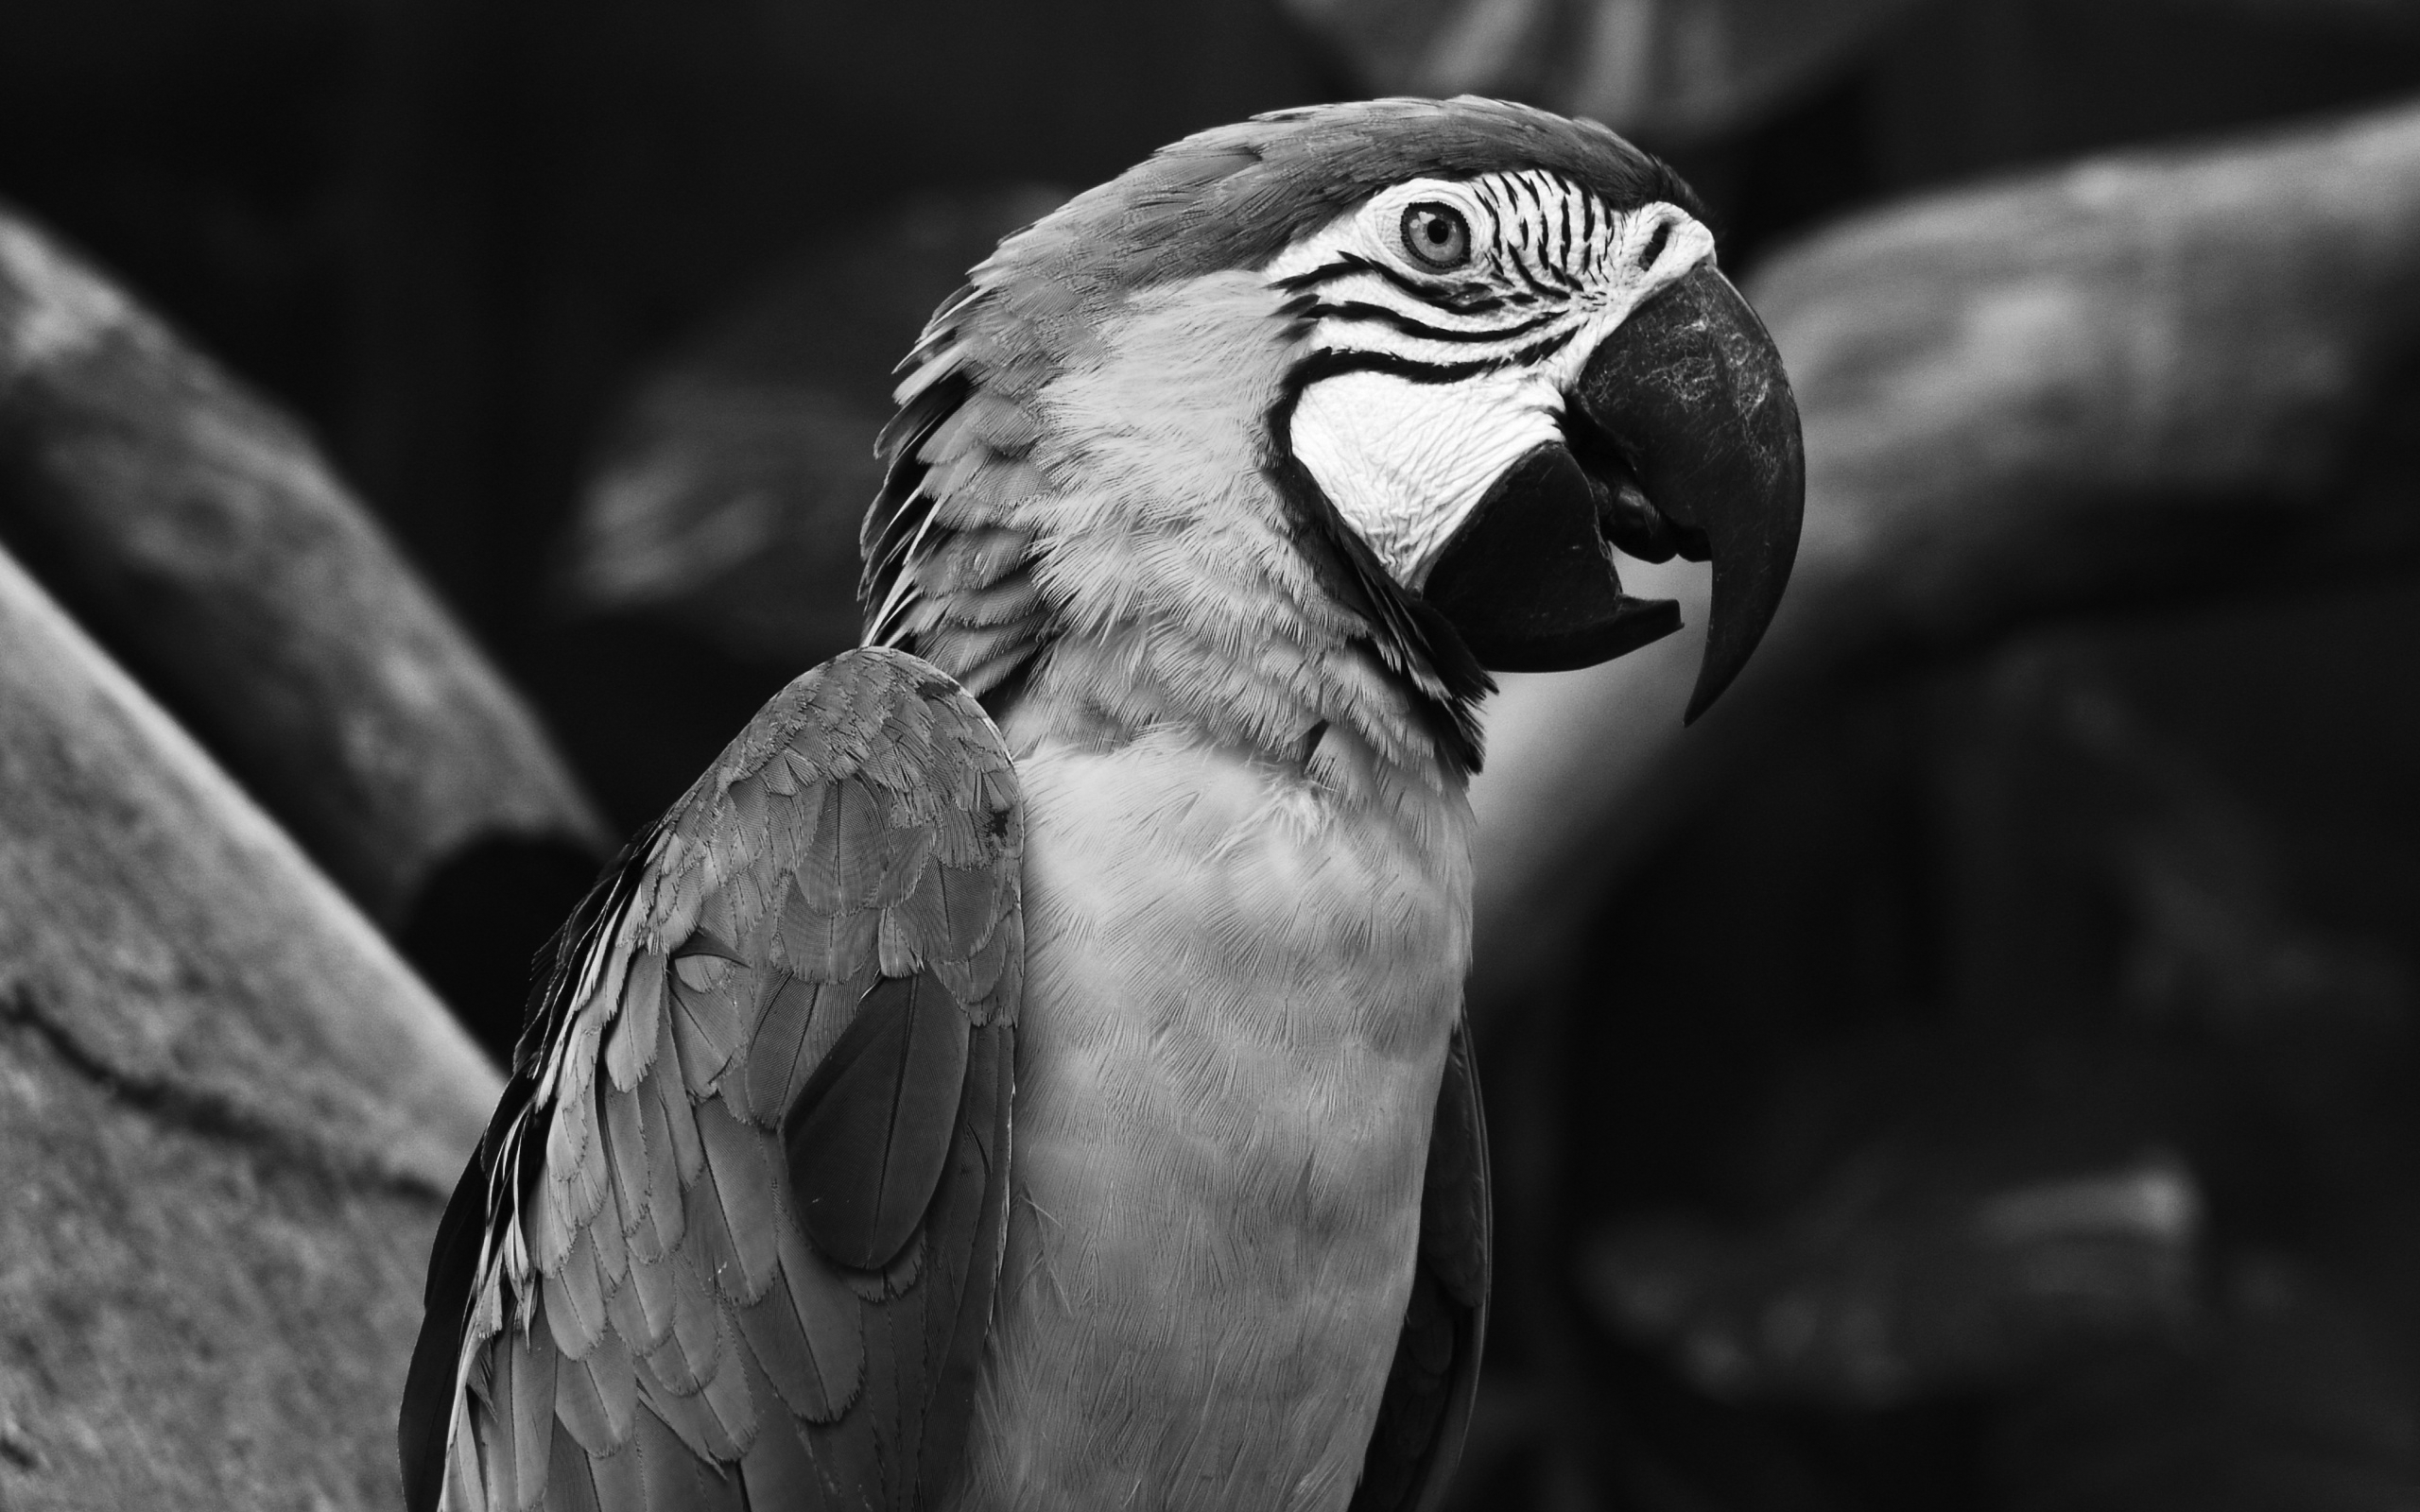

In [6]:
# open image as a data array
parrot = np.array(Image.open('big_parrot.png'), np.float32)
showimg(parrot)

In [7]:
# define "blur" in our DSL

# this @proc "decorator" specifies that
# the following function is written in SYS-ATL
@proc
def blur(N: size, M: size, K: size,      # size args specify sizes of other arguments
         image  : R[N, M],          # an N x M array; for input
         kernel : R[K, K],
         res    : R[N, M]):        # an N x M array; for output
    
    for x in par(0, N):                  # zero out the `res`ult array
        for y in par(0, M):
            res[x, y] = 0.0
    
    for x in par(0, N):                  # loop nest specifying the blur
        for y in par(0, M):
            for i in par(0, K):
                for j in par(0, K):
                    if x+i < N and y+j < M:
                        res[x, y] += kernel[i, j] * image[x+i, y+j]

blur                                     # show the resulting code

```python
def blur(N: size, M: size, K: size, image: R[N, M] @ DRAM,
         kernel: R[K, K] @ DRAM, res: R[N, M] @ DRAM):
    for x in par(0, N):
        for y in par(0, M):
            res[x, y] = 0.0
    for x in par(0, N):
        for y in par(0, M):
            for i in par(0, K):
                for j in par(0, K):
                    if x + i < N and y + j < M:
                        res[x, y] += kernel[i, j] * image[x + i, y + j]

```

In [8]:
# SYS-ATL is designed to trivially compile into C code
blur.show_c_code()

```c
int _floor_div(int num, int quot) {
  int off = (num>=0)? 0 : quot-1;
  return (num-off)/quot;
}


// blur(
//     N : size,
//     M : size,
//     K : size,
//     image : R[N_1,M_2]  @DRAM,
//     kernel : R[K_3,K_3]  @DRAM,
//     res : R[N_1,M_2]  @DRAM
// )
void blur( int N, int M, int K, float* image, float* kernel, float* res ) {
for (int x=0; x < N; x++) {
  for (int y=0; y < M; y++) {
    res[(x) * M + (y)] = 0.0;
  }
}
for (int x=0; x < N; x++) {
  for (int y=0; y < M; y++) {
    for (int i=0; i < K; i++) {
      for (int j=0; j < K; j++) {
        if (x + i < N && y + j < M) {
          res[(x) * M + (y)] += kernel[(i) * K + (j)] * image[(x + i) * M + (y + j)];
        }
      }
    }
  }
}
}

```

In [9]:
# now, let's collect and name all the arguments we'll use
# to call the procedure with
N, M       = parrot.shape
K          = 3
kernel     = np.array([[0.0625, 0.1250, 0.0625],
                       [0.1250, 0.2500, 0.1250],
                       [0.0625, 0.1250, 0.0625]], dtype=np.float32)
result     = np.zeros([N,M], dtype=np.float32)
blurargs   = [N,M,K, parrot, kernel, result] # useful shorthand
print("the size is...")
(N,M)

the size is...


(1600, 2560)

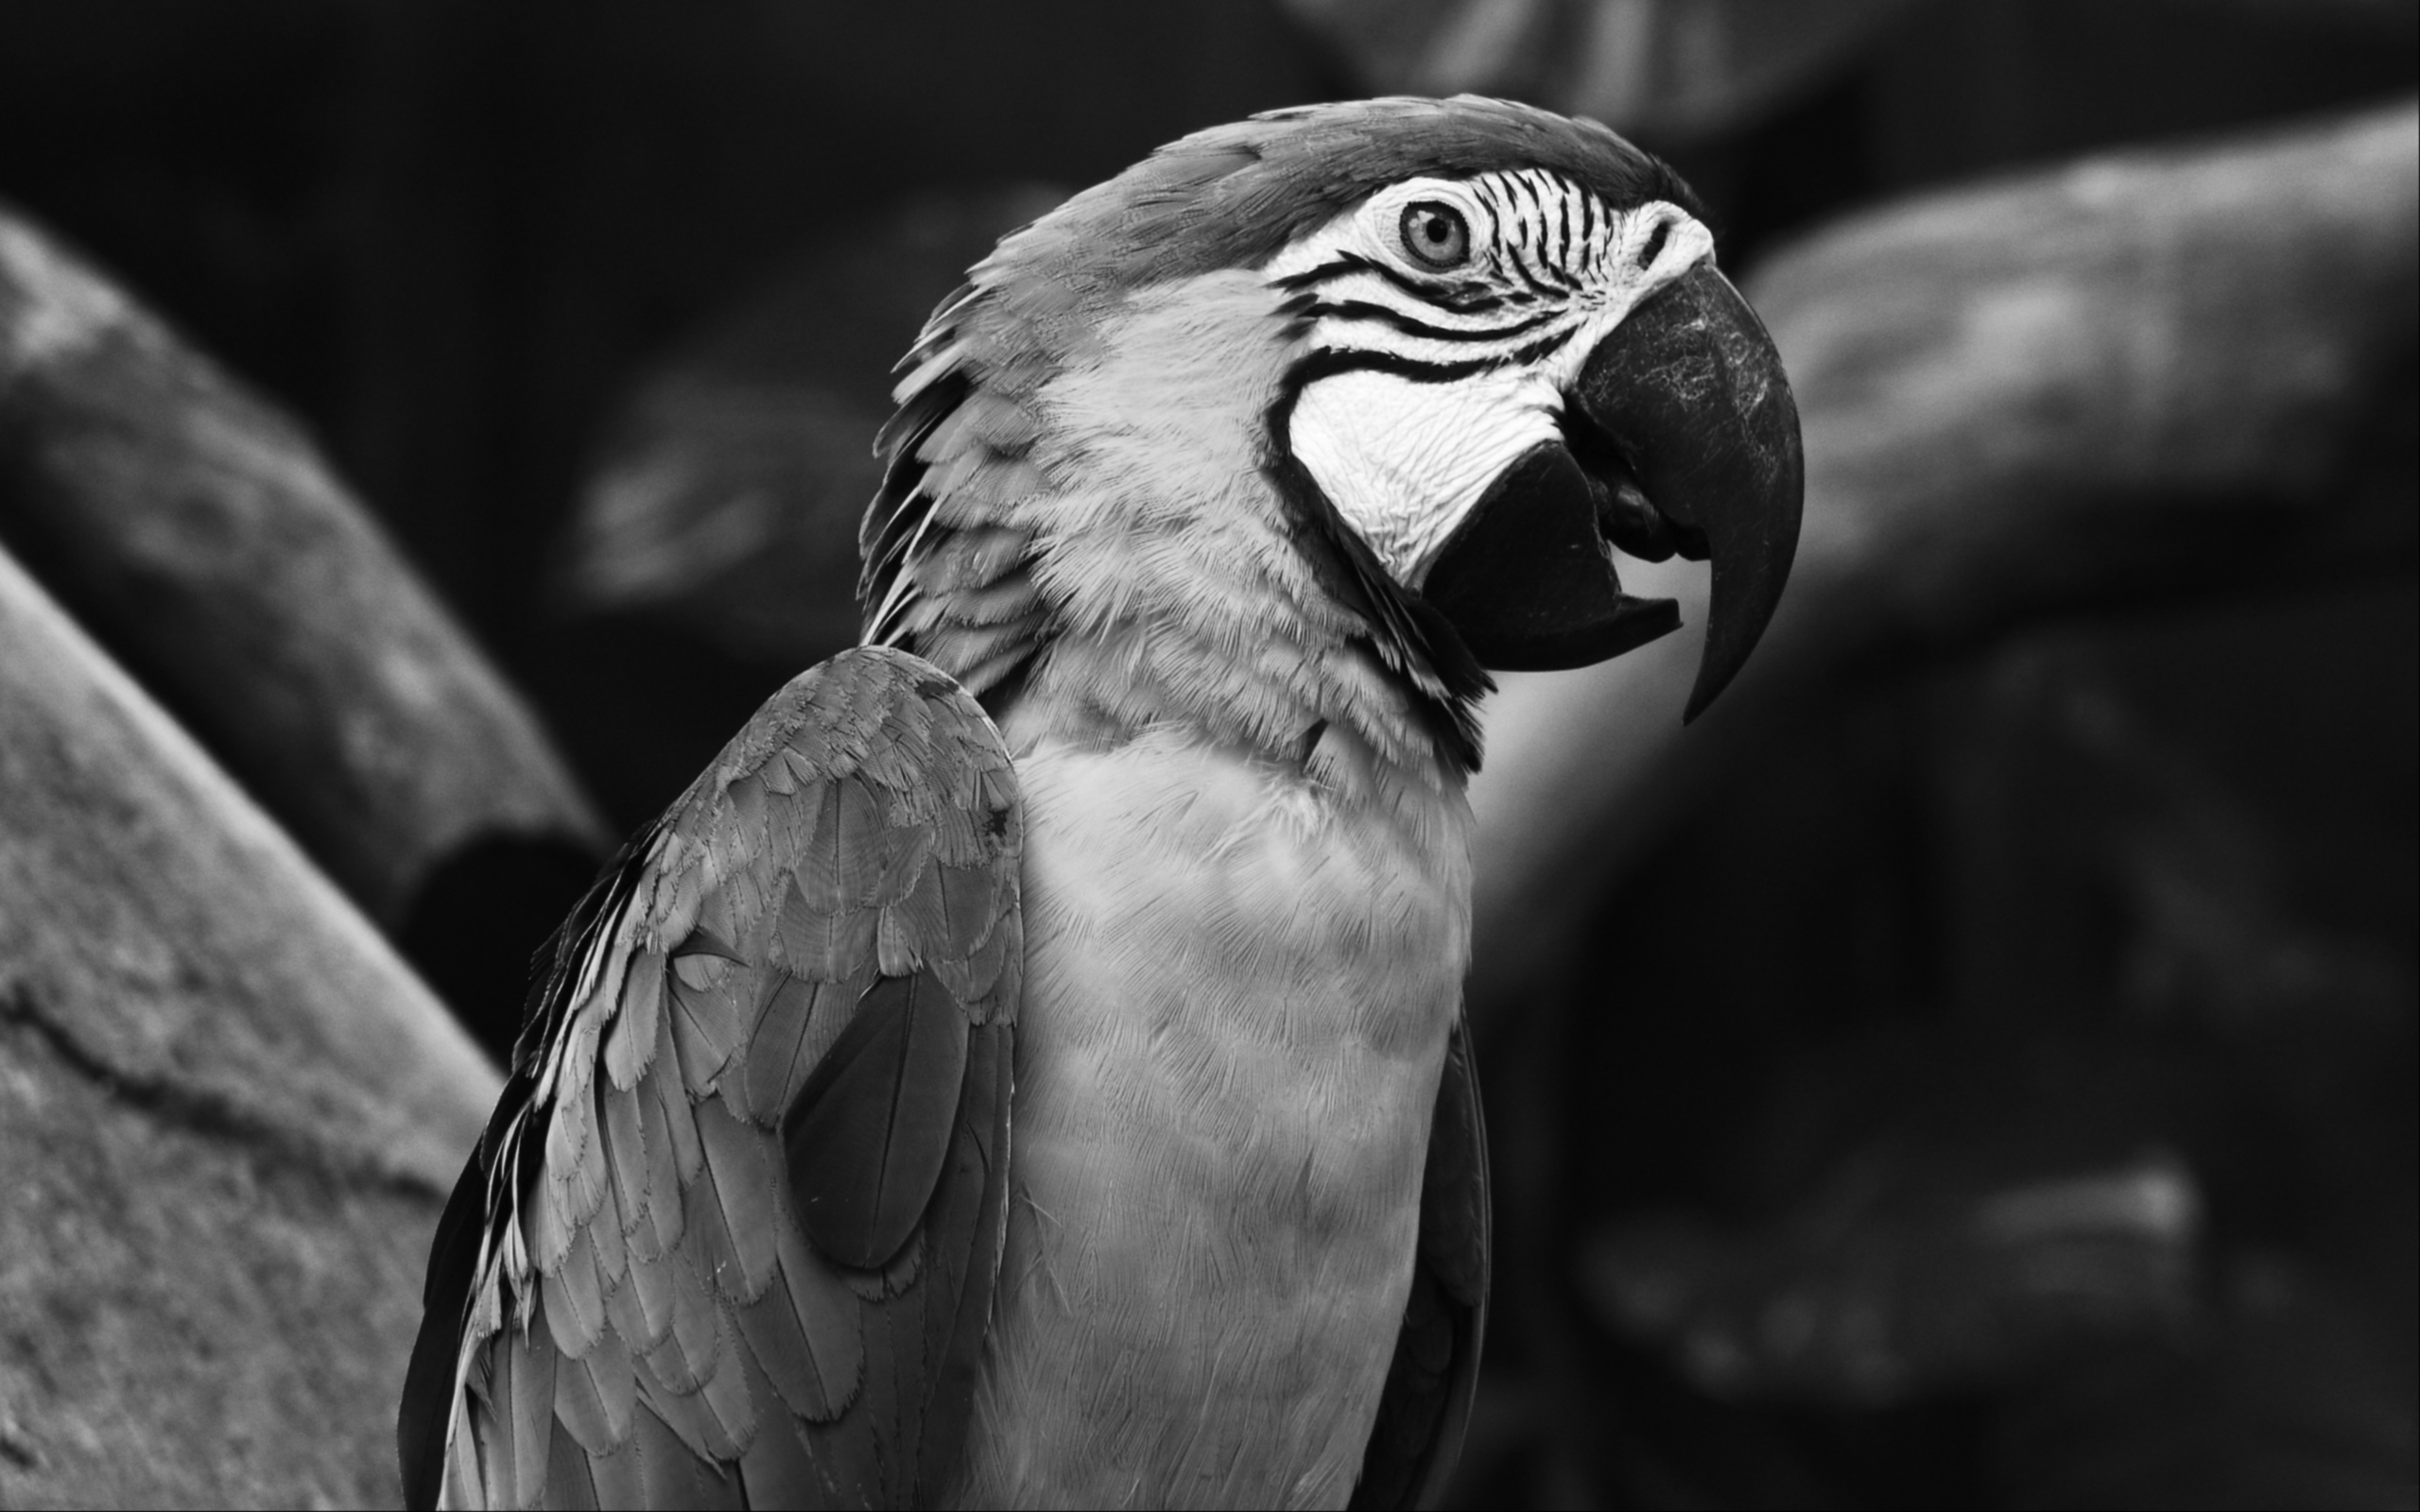

In [10]:
# in normal use, we'll dump that C-code to a file and use
# a makefile toolchain, but for the sake of this demo
# we'll use a simple jit-compilation wrapper so we
# can keep working inside of this notebook.

c_blur = blur.jit_compile()
c_blur(N=N,M=M,K=K, image=parrot, kernel=kernel, res=result)
showimg(result)

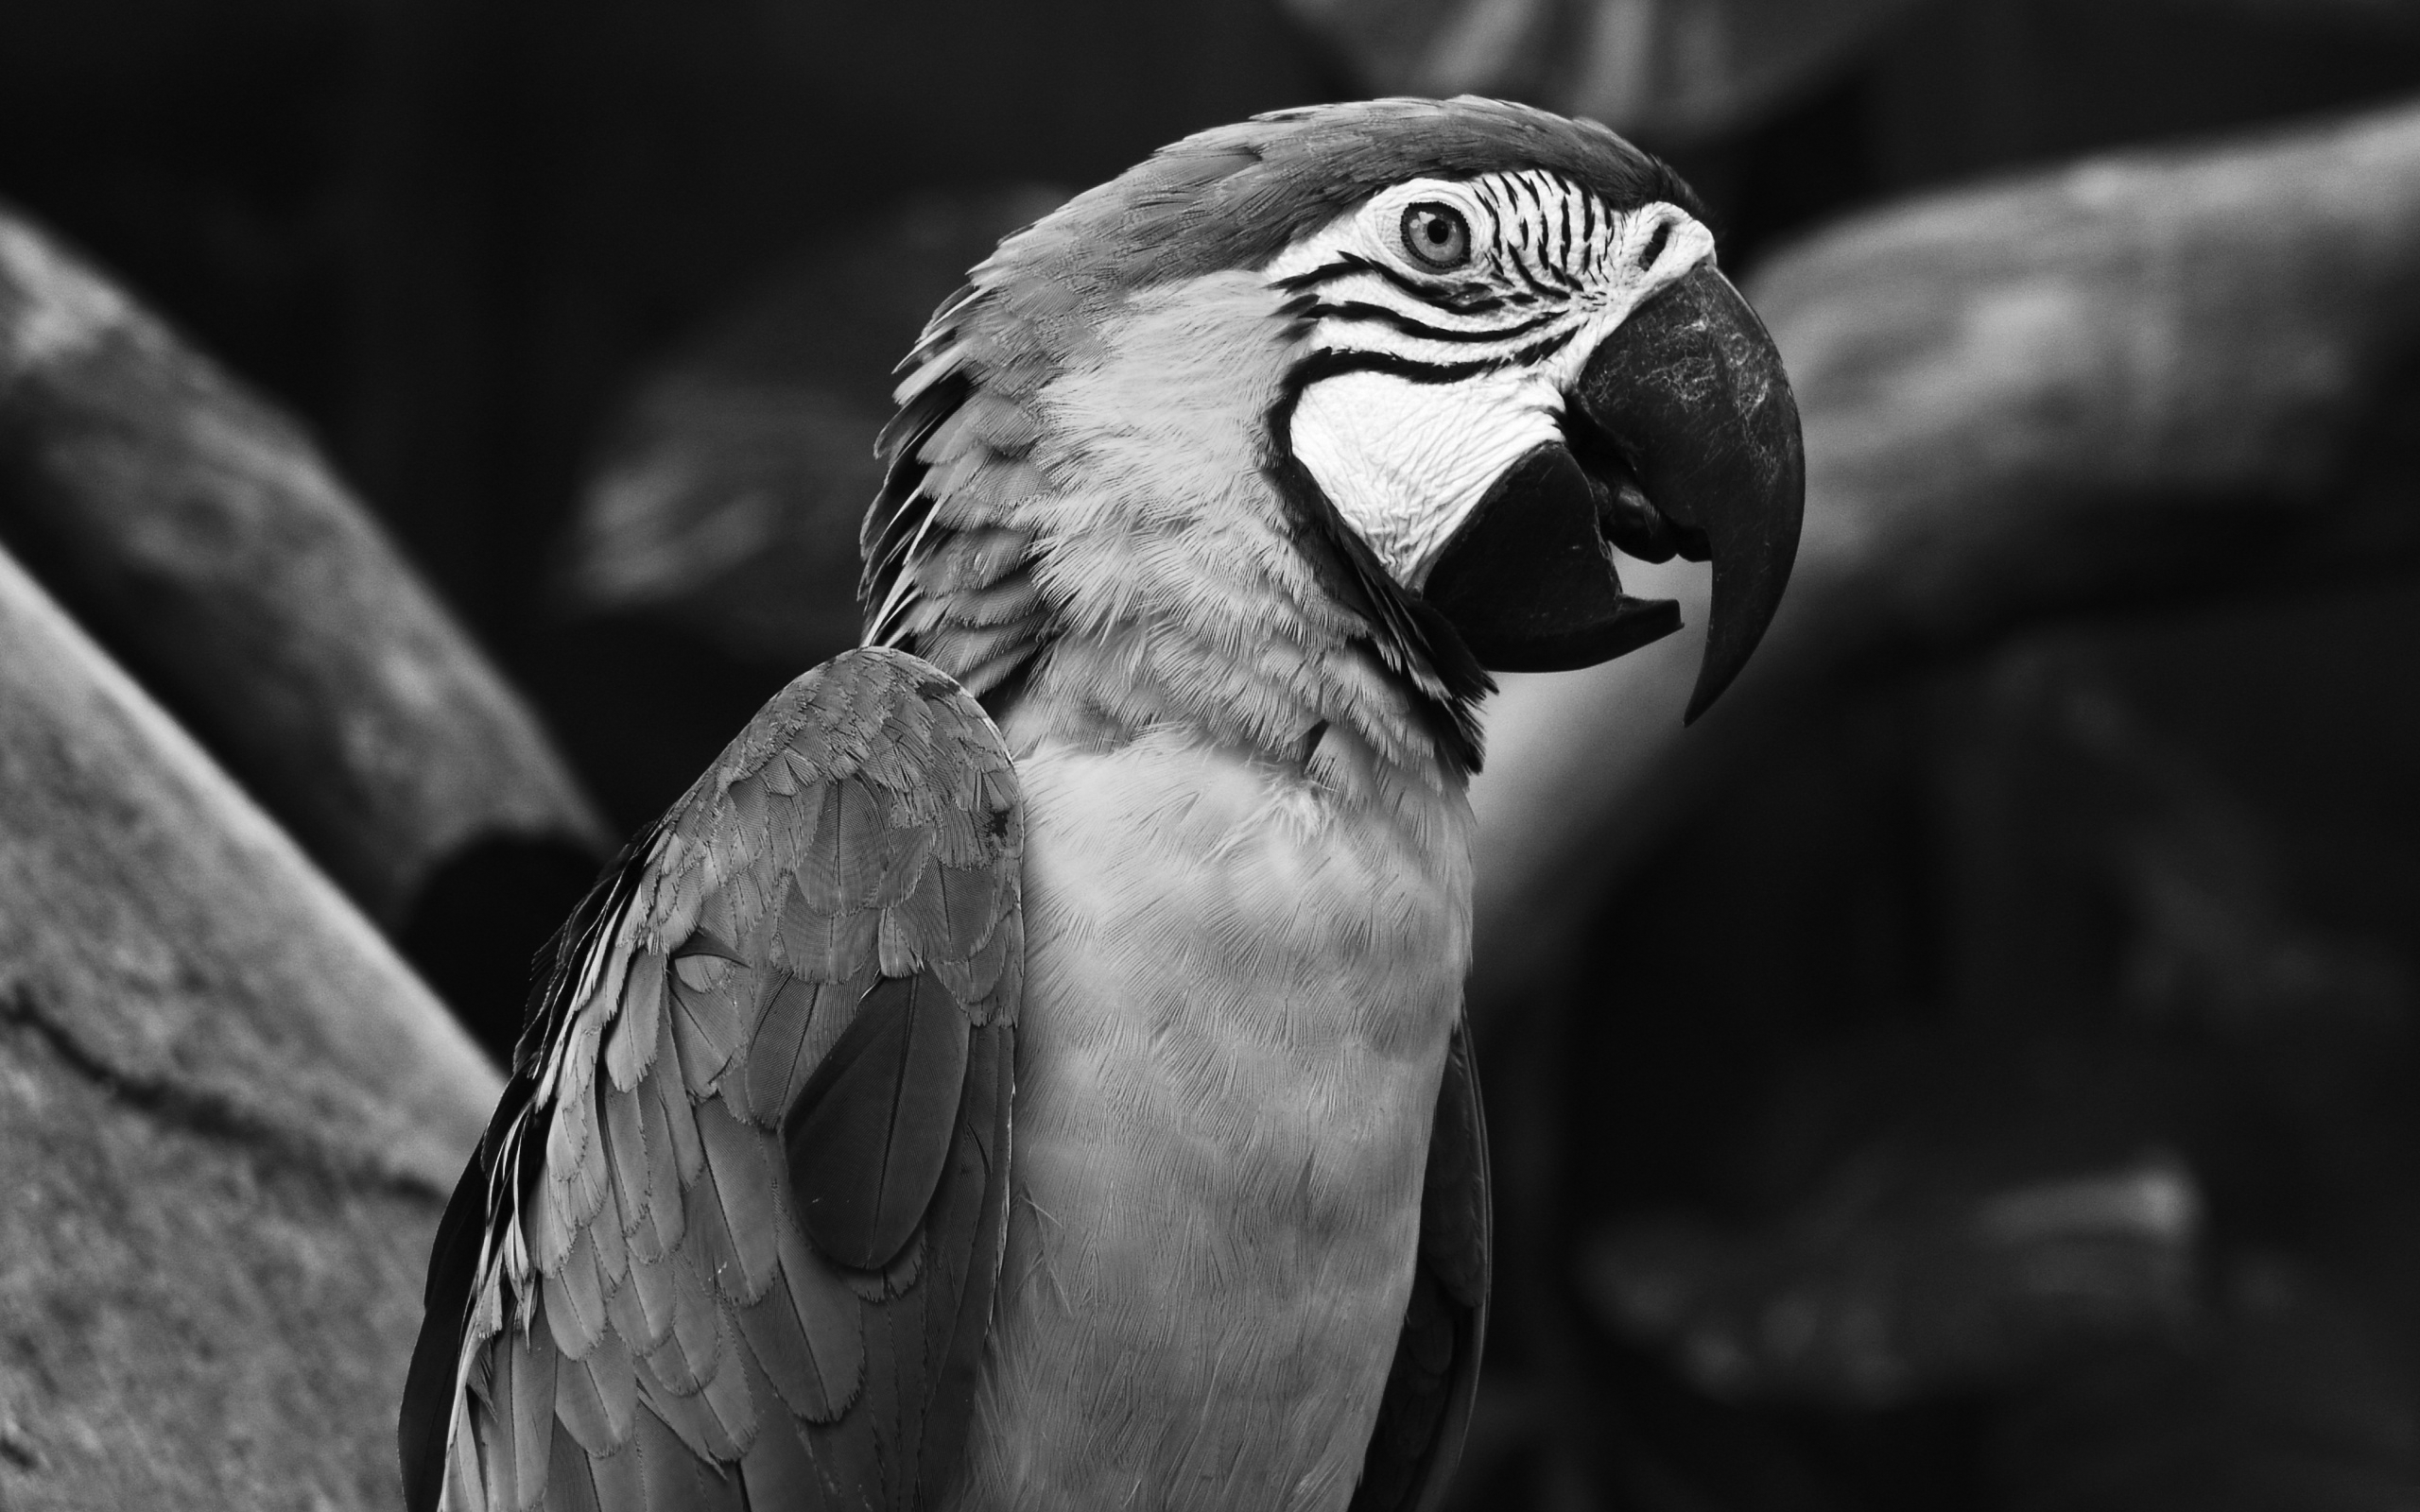

In [11]:
# let's compare to the original parrot
showimg(parrot)

In [12]:
# Ok, let's time this original version of blur...
show_report = True

def take_timing(proc, *args, **kwargs):
    n_runs           = 10
    lo, total, hi    = 1.0e6, 0.0, 0.0
    cproc            = proc.jit_compile()
    cproc(*args, **kwargs)
    
    for _ in range(0,n_runs):
        start = time.perf_counter()
        cproc(*args, **kwargs)
        stop  = time.perf_counter()
        ms    = (stop-start)*1.0e3
        if ms < lo:
            lo = ms
        if ms > hi:
            hi = ms
        total += ms
    
    # report
    if show_report:
        print(f"timings for {proc.name()} in ms:\n"+
              f"    avg:   {total / n_runs}\n"+
              f"    min:   {lo}\n"+
              f"    max:   {hi}\n")
    
    return (total / n_runs)


In [13]:
take_timing(blur, N,M,K, parrot, kernel, result)

timings for blur in ms:
    avg:   48.400730499997735
    min:   46.53891299994939
    max:   50.35830300005273



48.400730499997735

# Scheduling Example (Tiling)

In [14]:
# observe what happens when we iterate over the image
# in the wrong way relative to its storage order
bad_blur = blur.rename('bad_blur')
bad_blur = bad_blur.reorder('x','y')
bad_blur

```python
def bad_blur(N: size, M: size, K: size, image: R[N, M] @ DRAM,
             kernel: R[K, K] @ DRAM, res: R[N, M] @ DRAM):
    for y in par(0, M):
        for x in par(0, N):
            res[x, y] = 0.0
    for y in par(0, M):
        for x in par(0, N):
            for i in par(0, K):
                for j in par(0, K):
                    if x + i < N and y + j < M:
                        res[x, y] += kernel[i, j] * image[x + i, y + j]

```

In [15]:
orig     = take_timing(blur, *blurargs)
bad      = take_timing(bad_blur, *blurargs)
print('slowdown is ', bad / orig)

timings for blur in ms:
    avg:   47.967979700013075
    min:   45.513077000009616
    max:   50.35066900006768

timings for bad_blur in ms:
    avg:   149.9289765000185
    min:   143.11791499994797
    max:   158.80020700001296

slowdown is  3.125605402555189


In [17]:
# in order to tile, we need to split some loops
split_blur = blur.rename('split_blur')
split_blur = split_blur.split('x[2]', 8, ['xhi','xlo'])
split_blur

```python
def split_blur(N: size, M: size, K: size, image: R[N, M] @ DRAM,
               kernel: R[K, K] @ DRAM, res: R[N, M] @ DRAM):
    for x in par(0, N):
        for y in par(0, M):
            res[x, y] = 0.0
    for xhi in par(0, N / 8):
        for xlo in par(0, 8):
            if 8 * xhi + xlo < N:
                for y in par(0, M):
                    for i in par(0, K):
                        for j in par(0, K):
                            if 8 * xhi + xlo + i < N and y + j < M:
                                res[8 * xhi + xlo,
                                    y] += kernel[i, j] * image[8 * xhi + xlo +
                                                               i, y + j]

```

In [ ]:
# notice that the split scheduling primitive
# must introduce additional if-guards to ensure
# that all array accesses remain in-bounds

# Alternatively, we can tell .split(...) to
# ensure safety via a different "tail-strategy"
split_blur = blur.rename('split_blur')
split_blur = split_blur.split('x[2]', 8, ['xhi','xlo'], cut_tail=True)
split_blur

In [ ]:
# Then, we can similarly split the inner y-loop
split_blur = split_blur.split('y[2]', 8, ['yhi','ylo'], cut_tail=True)
split_blur

In [ ]:
# In order to accomplish tiling, we need to
# wrap the two different split y loops in two
# different copies of the `for xlo in ...` loop

# This is an instance of loop-fissioning
split_blur = split_blur.fission_after("for yhi in _: _")
split_blur

In [ ]:
# now we can finish up the tiling transform by re-ordering the
# lower order x iteration with the higher order y iteration

# additionally, it turned out that moving the kernel iteration outside of this
# inner loop was essential
split_blur = (split_blur.reorder('xlo[1]','yhi')
                        .reorder('ylo[1]','i').reorder('xlo[1]','i')
                        .reorder('ylo[1]','j').reorder('xlo[1]','j'))
split_blur

In [ ]:
# now, let's go ahead and test our hypothesis:
# that tiling will give us a performance improvement
orig     = take_timing(blur, *blurargs)
split    = take_timing(split_blur, *blurargs)
print('speedup is ', orig / split)

In [ ]:
# We chose to split by a factor of 8,
# but one natural aspect of scheduling is
# to tune this factor.

# We can quickly build a test harness to explore this parameter
def tile_by(n_x,n_y):
    
    test_blur = (blur.rename('test_blur')
                     # split the loops we want to tile together
                     .split('x[2]', n_x, ['xhi','xlo'], cut_tail=True)
                     .split('y[2]', n_y, ['yhi','ylo'], cut_tail=True)
                     # push the `for xlo in _` loop down over the y-loop split
                     .fission_after("for yhi in _: _")
                     # complete the tiling by moving both lower-order loops
                     # beneath both higher-order loops
                     .reorder('xlo[1]','yhi')
                     # finally, a magic improvement is to exchange the filter iteration order
                     .reorder('ylo[1]','i').reorder('xlo[1]','i')
                     .reorder('ylo[1]','j').reorder('xlo[1]','j')
                )
    test    = take_timing(test_blur, *blurargs)
    print(f"({n_x:3d}, {n_y:3d}):   {test:8.3f}")

show_report = False
print("params        test (ms)")
for n_x,n_y in [(4,4),
                (4,8),
                (8,8),
                (8,16),
                (16,16),
                (16,32),
                (32,32),
                (32,64),
                (64,64),
                (128,128)]:
    tile_by(n_x,n_y)